#### In this notebook, we are going to simplify our problem and take a bottom-up approach to see how learnable it is.

#### Previously, the problem statement was "Given a query dataset Q and a set of candidate datasets, identify the subset X such that that every C \in X, once integrated to Q through a left outer join, leads to a successful data augmentation."

#### Given that "successful" is defined as any relative improvement regarding R-squared score, and that there is currently a huge overlap in our features for augmentation examples of both kinds (successful and unsuccessful), we want to first understand whether there are features that help predict whether a REALLY GOOD or a REALLY BAD candidate truly lead to a successful or unsuccessful augmentation (respectively). 

#### Since we're having problems with our training data (too much feature overlap, bias towards high containment, hard to understand how representative it is of real problems...), we're going to start by (1) simplifying training and test, and by (2) using a simple classifier based on the candidate's pearson wrt the target ALONE. After that, we'll complicate the cases little by little and see what happens.

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report

ALL_FEATURES = ['query_num_of_columns', 'query_num_of_rows', 'query_row_column_ratio',
                'query_max_skewness', 'query_max_kurtosis', 'query_max_unique', 
                'candidate_num_rows', 'candidate_max_skewness', 'candidate_max_kurtosis',
                'candidate_max_unique', 'query_target_max_pearson', 
                'query_target_max_spearman', 'query_target_max_covariance', 
                'query_target_max_mutual_info', 'candidate_target_max_pearson', 
                'candidate_target_max_spearman', 'candidate_target_max_covariance', 
                'candidate_target_max_mutual_info']
CANDIDATE_PEARSON = ['candidate_target_max_pearson'] 

In [2]:
openml_train = pd.read_csv('training-simplified-data-generation-many-candidates-per-query_with_median_and_mean_based_classes.csv')

In [3]:
openml_train.head()

,query,target,candidate,gain_marker,query_num_of_columns,query_num_of_rows,query_row_column_ratio,query_max_mean,query_max_outlier_percentage,query_max_skewness,...,containment_fraction,decrease_in_mae,decrease_in_mse,decrease_in_medae,gain_in_r2_score,r2_score_before,r2_score_after,median_based_class,mean_based_class,class
0,6d906397-2a45-49b8-aa3f-b3929656ed41,class,968ccfab-977f-48b1-a8d2-5b796d6de36f,negative,12.0,67557.0,5629.750000,0.992347,0.065811,61.239966,...,1.0,0.023279,0.370818,-0.067544,-5.936368,0.058793,-0.290223,loss,loss,loss
1,6d906397-2a45-49b8-aa3f-b3929656ed41,class,968ccfab-977f-48b1-a8d2-5b796d6de36f,negative,12.0,67557.0,5629.750000,0.992347,0.065811,61.239966,...,1.0,0.023279,0.370818,-0.067544,-5.936368,0.058793,-0.290223,loss,loss,loss
2,3bd611e5-7610-43ee-b5f8-44279666b94b,1.8021959e+000,b03b55ec-3c92-49d7-99a8-f525f33d9067,negative,14.0,99.0,7.071429,0.018204,0.000000,0.321709,...,1.0,0.014811,0.035743,-0.080799,-0.094102,0.275274,0.249371,loss,loss,loss
3,3bd611e5-7610-43ee-b5f8-44279666b94b,1.8021959e+000,b03b55ec-3c92-49d7-99a8-f525f33d9067,negative,14.0,99.0,7.071429,0.018204,0.000000,0.321709,...,1.0,0.014811,0.035743,-0.080799,-0.094102,0.275274,0.249371,loss,loss,loss
4,3bd611e5-7610-43ee-b5f8-44279666b94b,1.8021959e+000,b03b55ec-3c92-49d7-99a8-f525f33d9067,negative,14.0,99.0,7.071429,0.018204,0.000000,0.321709,...,1.0,0.014811,0.035743,-0.080799,-0.094102,0.275274,0.249371,loss,loss,loss


#### First step: remove everything from training whose containment fraction is different from one. This diminishes the interference that missing value imputation may be having.

In [4]:
def remove_low_containment_fraction_entries(dataset, threshold=1.0):
    return dataset.loc[dataset['containment_fraction'] >= threshold]

In [5]:
openml_train = remove_low_containment_fraction_entries(openml_train)
openml_train.shape

(1100700, 39)

In [6]:
openml_test = pd.read_csv('test-simplified-data-generation.csv')
openml_test = remove_low_containment_fraction_entries(openml_test)

#### Now let's plot the different feature distributions for this first simplification.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
OUTLIER_THRESHOLD_MAD = 3
def remove_outliers_based_on_mad(feature):
  mad = feature.mad() #median_absolute_deviation(feature)
  median = np.median(feature)
  return [i for i in feature if np.fabs((i - median)/mad) < OUTLIER_THRESHOLD_MAD]


def plot_two_kinds_of_histograms(data1, label1, data2, label2):
  """ This function plots histograms for features and targets, just like                                                                                                          
  function 'plot_features_and_target_histograms' for two different data (data1 and data2)                                                                                         
  """
  for feature_name in ALL_FEATURES:                                                                                                                        
    tmp1 = remove_outliers_based_on_mad(data1[feature_name])                                                                                                 
    tmp2 = remove_outliers_based_on_mad(data2[feature_name])                                                                                                 
    plt.hist(tmp1, bins=50, alpha=0.7, label=label1, color='blue')
    plt.hist(tmp2, bins=50, alpha=0.7, label=label2, color='red')
    plt.xlabel('Value Ranges')
    plt.ylabel('Percentages')
    plt.title(feature_name)                                                                                                         
    plt.legend()
    plt.show() 

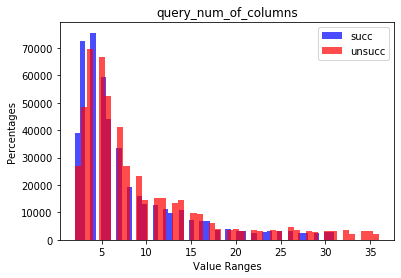

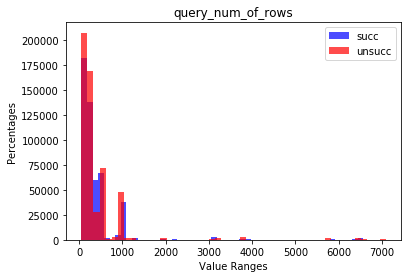

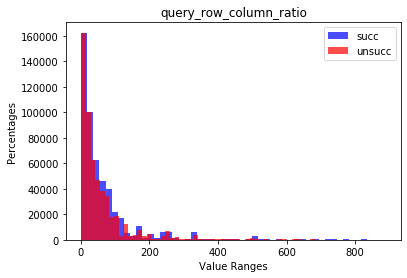

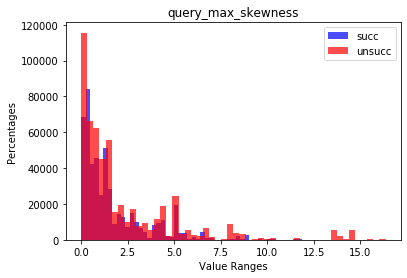

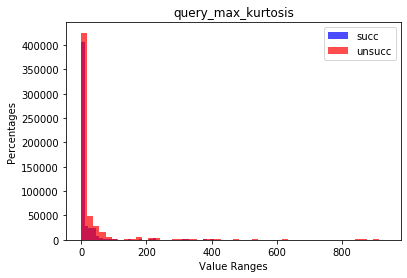

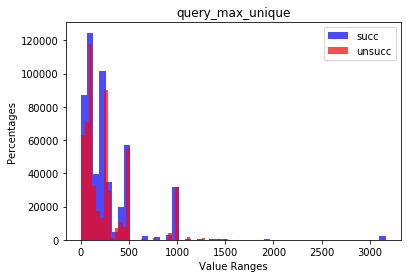

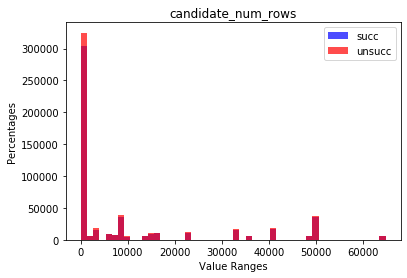

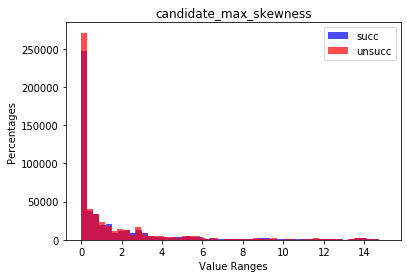

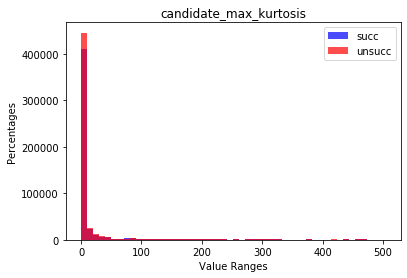

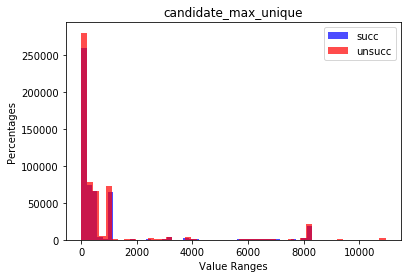

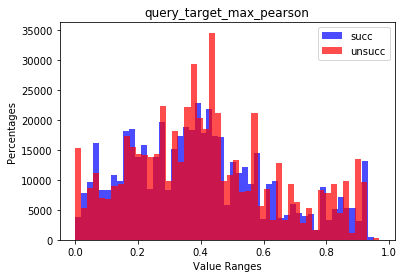

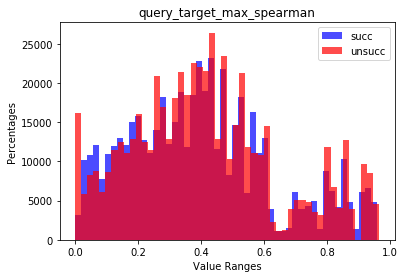

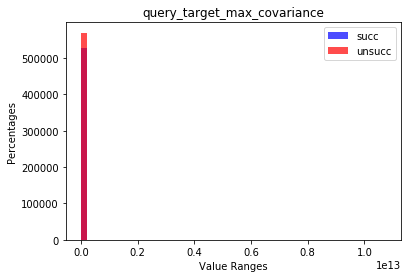

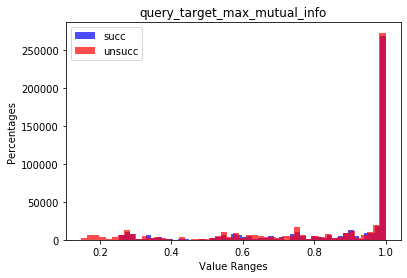

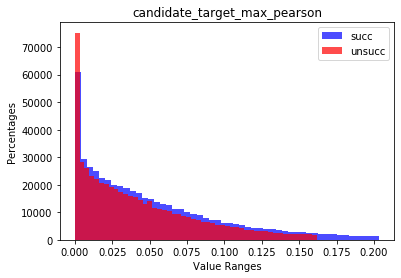

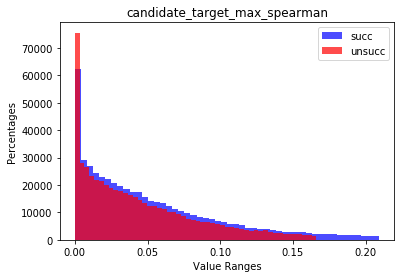

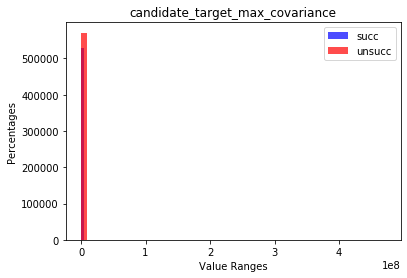

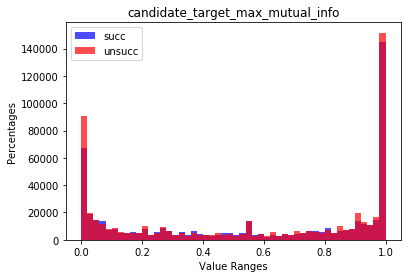

In [8]:
openml_train['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in openml_train.iterrows()]
openml_test['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in openml_test.iterrows()]

succ = openml_train.loc[openml_train['class'] == 'gain']#.sample(n=4000)
unsucc = openml_train.loc[openml_train['class'] == 'loss']#.sample(n=4000)
plot_two_kinds_of_histograms(succ, 'succ', unsucc, 'unsucc')

#### It seems that these features are still not very good at separating the training data. Let's see how it works for the simplified version of openml_test.

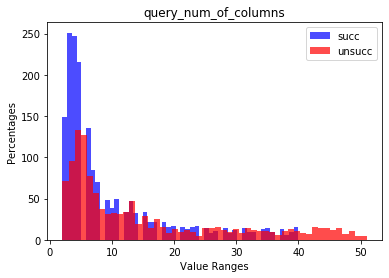

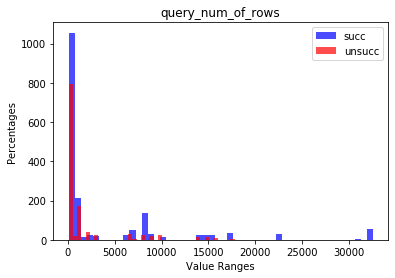

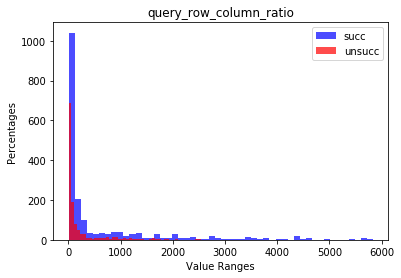

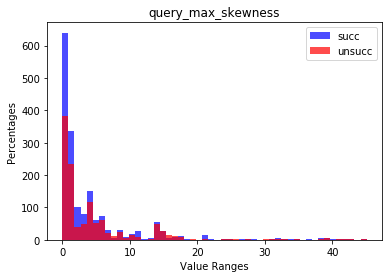

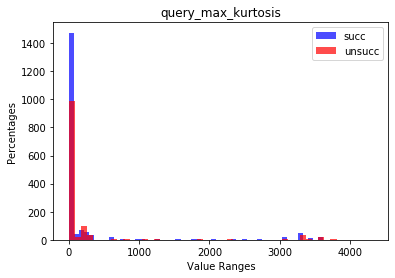

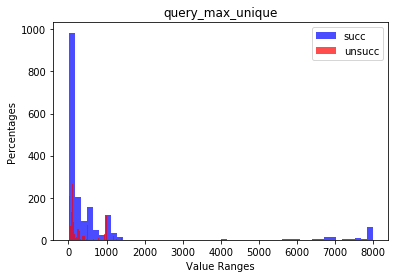

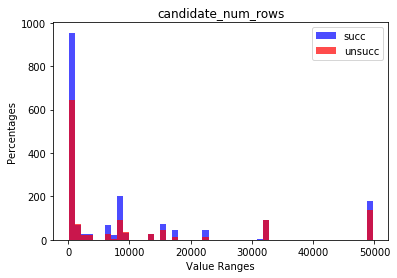

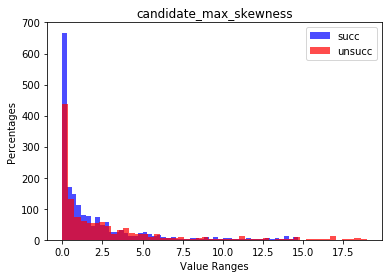

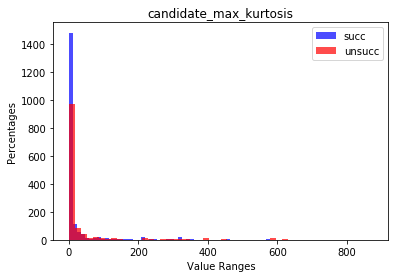

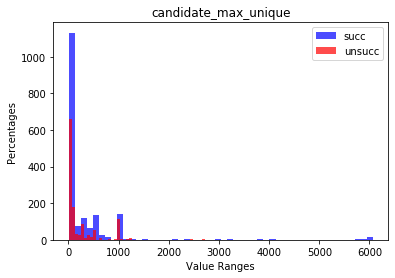

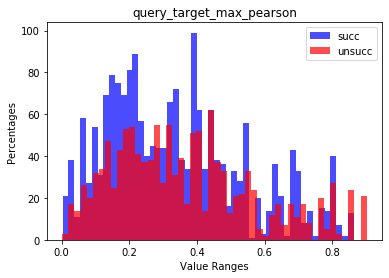

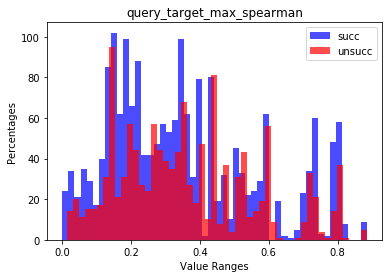

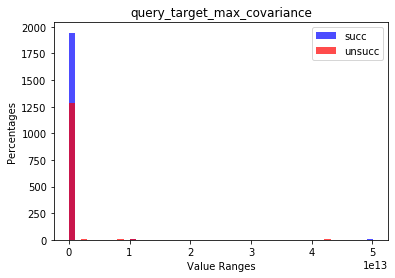

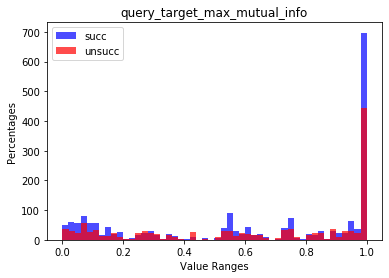

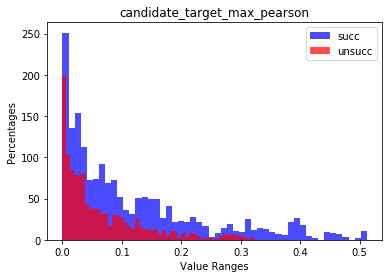

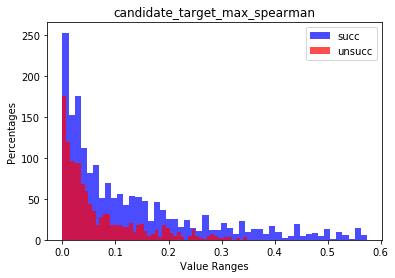

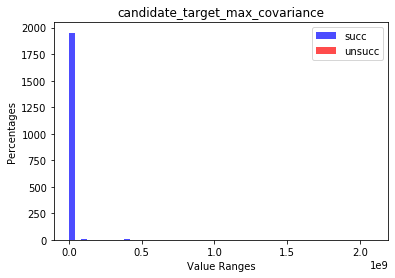

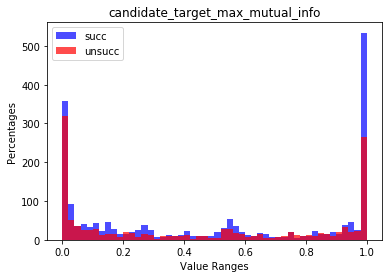

In [9]:
succ = openml_test.loc[openml_test['class'] == 'gain']#.sample(n=4000)
unsucc = openml_test.loc[openml_test['class'] == 'loss']#.sample(n=4000)
plot_two_kinds_of_histograms(succ, 'succ', unsucc, 'unsucc')

#### It seems like the separation is better here. Now, following the bottom-up approach, let's steer our attention to only one feature: candidate_target_max_pearson. Given that candidate datasets only have ONE NUMERICAL COLUMN, 'max' is not really aggregating/hiding any info.

In [10]:
openml_train_pearson = openml_train[['candidate_target_max_pearson', 'gain_in_r2_score', 'class']]
openml_test_pearson = openml_test[['candidate_target_max_pearson', 'gain_in_r2_score', 'class']]

#### Let's check the Pearson correlation between 'candidate_target_max_pearson' and 'gain_in_r2_score' first.

In [11]:
from scipy.stats import pearsonr

In [12]:
pearsonr(openml_train_pearson['candidate_target_max_pearson'], openml_train_pearson['gain_in_r2_score'])

(0.009163921420636677, 6.94793788042789e-22)

In [13]:
pearsonr(openml_test_pearson['candidate_target_max_pearson'], openml_test_pearson['gain_in_r2_score'])

(0.02862020706113722, 0.10203386051941381)

#### Bad correlations. What if I normalize these values?

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

std_openml_train_pearson = standard_scaler.fit_transform(openml_train_pearson[['candidate_target_max_pearson', 'gain_in_r2_score']])
minmax_openml_train_pearson = minmax_scaler.fit_transform(openml_train_pearson[['candidate_target_max_pearson', 'gain_in_r2_score']])
std_openml_test_pearson = standard_scaler.fit_transform(openml_test_pearson[['candidate_target_max_pearson', 'gain_in_r2_score']])
minmax_openml_test_pearson = minmax_scaler.fit_transform(openml_test_pearson[['candidate_target_max_pearson', 'gain_in_r2_score']])


In [15]:
pearsonr(std_openml_train_pearson[:,0], std_openml_train_pearson[:,1])

(0.009163921420636678, 6.94793788042789e-22)

In [16]:
pearsonr(minmax_openml_train_pearson[:,0], minmax_openml_train_pearson[:,1])

(0.009163921420636687, 6.94793788042789e-22)

In [17]:
pearsonr(std_openml_test_pearson[:,0], std_openml_test_pearson[:,1])

(0.02862020706113722, 0.10203386051941381)

In [18]:
pearsonr(minmax_openml_test_pearson[:,0], minmax_openml_test_pearson[:,1])

(0.02862020706113721, 0.10203386051941381)

#### Made no difference (as expected, honestly). Let me see how classification works using 'candidate_target_max_pearson' alone.

In [20]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(openml_train_pearson[CANDIDATE_PEARSON], openml_train_pearson['class'])


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
preds = rf.predict(openml_test_pearson[CANDIDATE_PEARSON])
print(classification_report(openml_test_pearson['class'], preds))

#### Not that bad. Now let's see for the case studies (again, containment_fraction = 1 always)

In [22]:
college = pd.read_csv('college-debt-records-features-single-column-w-class')
college['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in college.iterrows()]

poverty = pd.read_csv('poverty-estimation-results-features-and-targets-training.csv')
poverty['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in poverty.iterrows()]

taxi = pd.read_csv('taxi-vehicle-collision-records-features-single-column-w-class-normalized-with-mad.csv')
taxi['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in taxi.iterrows()]

In [23]:
college = remove_low_containment_fraction_entries(college)
poverty = remove_low_containment_fraction_entries(poverty)
taxi = remove_low_containment_fraction_entries(taxi)

In [24]:
preds = rf.predict(college[CANDIDATE_PEARSON])
print(classification_report(college['class'], preds))

              precision    recall  f1-score   support

        gain       1.00      0.67      0.80         6
        loss       0.60      1.00      0.75         3

    accuracy                           0.78         9
   macro avg       0.80      0.83      0.77         9
weighted avg       0.87      0.78      0.78         9



In [25]:
preds = rf.predict(poverty[CANDIDATE_PEARSON])
print(classification_report(poverty['class'], preds))

              precision    recall  f1-score   support

        gain       1.00      0.45      0.62        11
        loss       0.00      0.00      0.00         0

    accuracy                           0.45        11
   macro avg       0.50      0.23      0.31        11
weighted avg       1.00      0.45      0.62        11



/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
preds = rf.predict(taxi[CANDIDATE_PEARSON])
print(classification_report(taxi['class'], preds))

              precision    recall  f1-score   support

        gain       1.00      0.80      0.89        66
        loss       0.00      0.00      0.00         0

    accuracy                           0.80        66
   macro avg       0.50      0.40      0.45        66
weighted avg       1.00      0.80      0.89        66



/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### The results are good when we consider only containment_fraction = 1 and pearson. 

#### POTENTIAL STRATEGY 1: use containment_fraction as a hyperparameter, and pick a threshold based on that (the moment you lower it and things get drastically worse, you stop).

#### POTENTIAL STRATEGY 2: have "layered" models targetting datasets with different containment_fractions, such that you just classify datasets with smaller containment fractions if the number of "higher-joined" datasets you've already classified is not enough.


In [27]:
def calculate_performance_for_different_containment_ratios(training, test_datasets):
    thresholds = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    for thresh in thresholds:
        tmp_training = remove_low_containment_fraction_entries(training, threshold=thresh)
        rf.fit(tmp_training[CANDIDATE_PEARSON], tmp_training['class'])
        for test_name in test_datasets.keys():
            tmp_test = remove_low_containment_fraction_entries(test_datasets[test_name], threshold=thresh)
            preds = rf.predict(tmp_test[CANDIDATE_PEARSON])
            print('****', test_name, 'containment_fraction >=', thresh)
            print(classification_report(tmp_test['class'], preds))

In [28]:
openml_train = pd.read_csv('training-simplified-data-generation-many-candidates-per-query_with_median_and_mean_based_classes.csv')
openml_train['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in openml_train.iterrows()]

openml_test = pd.read_csv('test-simplified-data-generation.csv')
openml_test['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in openml_test.iterrows()]

college = pd.read_csv('college-debt-records-features-single-column-w-class')
college['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in college.iterrows()]

poverty = pd.read_csv('poverty-estimation-results-features-and-targets-training.csv')
poverty['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in poverty.iterrows()]

taxi = pd.read_csv('taxi-vehicle-collision-records-features-single-column-w-class-normalized-with-mad.csv')
taxi['class'] = ['gain' if row['gain_in_r2_score'] > 0 else 'loss' for index, row in taxi.iterrows()]

In [30]:
test = {'openml_test': openml_test, 'college': college, 'poverty': poverty, 'taxi': taxi}

calculate_performance_for_different_containment_ratios(openml_train, test)

**** openml_test containment_fraction >= 1.0
              precision    recall  f1-score   support

        gain       0.67      0.62      0.65      1960
        loss       0.49      0.54      0.51      1305

    accuracy                           0.59      3265
   macro avg       0.58      0.58      0.58      3265
weighted avg       0.60      0.59      0.59      3265

**** college containment_fraction >= 1.0
              precision    recall  f1-score   support

        gain       1.00      0.67      0.80         6
        loss       0.60      1.00      0.75         3

    accuracy                           0.78         9
   macro avg       0.80      0.83      0.77         9
weighted avg       0.87      0.78      0.78         9

**** poverty containment_fraction >= 1.0
              precision    recall  f1-score   support

        gain       1.00      0.45      0.62        11
        loss       0.00      0.00      0.00         0

    accuracy                           0.45        11
 

/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**** taxi containment_fraction >= 1.0
              precision    recall  f1-score   support

        gain       1.00      0.80      0.89        66
        loss       0.00      0.00      0.00         0

    accuracy                           0.80        66
   macro avg       0.50      0.40      0.45        66
weighted avg       1.00      0.80      0.89        66

**** openml_test containment_fraction >= 0.9
              precision    recall  f1-score   support

        gain       0.67      0.62      0.65      1967
        loss       0.49      0.54      0.52      1314

    accuracy                           0.59      3281
   macro avg       0.58      0.58      0.58      3281
weighted avg       0.60      0.59      0.59      3281

**** college containment_fraction >= 0.9
              precision    recall  f1-score   support

        gain       0.93      0.62      0.74        84
        loss       0.40      0.84      0.54        25

    accuracy                           0.67       109
   m

/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**** openml_test containment_fraction >= 0.8
              precision    recall  f1-score   support

        gain       0.68      0.63      0.65      1977
        loss       0.50      0.55      0.52      1323

    accuracy                           0.60      3300
   macro avg       0.59      0.59      0.59      3300
weighted avg       0.60      0.60      0.60      3300

**** college containment_fraction >= 0.8
              precision    recall  f1-score   support

        gain       0.92      0.57      0.71        84
        loss       0.37      0.84      0.51        25

    accuracy                           0.63       109
   macro avg       0.65      0.71      0.61       109
weighted avg       0.80      0.63      0.66       109

**** poverty containment_fraction >= 0.8


/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        gain       1.00      0.45      0.62        11
        loss       0.00      0.00      0.00         0

    accuracy                           0.45        11
   macro avg       0.50      0.23      0.31        11
weighted avg       1.00      0.45      0.62        11

**** taxi containment_fraction >= 0.8
              precision    recall  f1-score   support

        gain       1.00      0.83      0.91        66
        loss       0.00      0.00      0.00         0

    accuracy                           0.83        66
   macro avg       0.50      0.42      0.45        66
weighted avg       1.00      0.83      0.91        66

**** openml_test containment_fraction >= 0.7
              precision    recall  f1-score   support

        gain       0.67      0.63      0.65      1991
        loss       0.49      0.54      0.52      1333

    accuracy                           0.59      3324
   macro avg       0.58      0.59      0.58  

/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**** openml_test containment_fraction >= 0.6
              precision    recall  f1-score   support

        gain       0.68      0.63      0.65      2026
        loss       0.49      0.55      0.52      1350

    accuracy                           0.59      3376
   macro avg       0.58      0.59      0.58      3376
weighted avg       0.60      0.59      0.60      3376

**** college containment_fraction >= 0.6
              precision    recall  f1-score   support

        gain       0.89      0.58      0.70        86
        loss       0.35      0.76      0.47        25

    accuracy                           0.62       111
   macro avg       0.62      0.67      0.59       111
weighted avg       0.77      0.62      0.65       111

**** poverty containment_fraction >= 0.6
              precision    recall  f1-score   support

        gain       1.00      0.55      0.71        11
        loss       0.00      0.00      0.00         0

    accuracy                           0.55        11
 

/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**** openml_test containment_fraction >= 0.5
              precision    recall  f1-score   support

        gain       0.67      0.62      0.65      2050
        loss       0.49      0.55      0.52      1371

    accuracy                           0.59      3421
   macro avg       0.58      0.59      0.58      3421
weighted avg       0.60      0.59      0.60      3421

**** college containment_fraction >= 0.5
              precision    recall  f1-score   support

        gain       0.89      0.63      0.74        92
        loss       0.35      0.72      0.47        25

    accuracy                           0.65       117
   macro avg       0.62      0.68      0.60       117
weighted avg       0.78      0.65      0.68       117

**** poverty containment_fraction >= 0.5
              precision    recall  f1-score   support

        gain       1.00      0.55      0.71        11
        loss       0.00      0.00      0.00         0

    accuracy                           0.55        11
 

/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**** openml_test containment_fraction >= 0.4
              precision    recall  f1-score   support

        gain       0.67      0.63      0.65      2082
        loss       0.50      0.54      0.52      1395

    accuracy                           0.60      3477
   macro avg       0.59      0.59      0.59      3477
weighted avg       0.60      0.60      0.60      3477

**** college containment_fraction >= 0.4
              precision    recall  f1-score   support

        gain       0.93      0.58      0.72        98
        loss       0.34      0.84      0.48        25

    accuracy                           0.63       123
   macro avg       0.64      0.71      0.60       123
weighted avg       0.81      0.63      0.67       123

**** poverty containment_fraction >= 0.4
              precision    recall  f1-score   support

        gain       1.00      0.64      0.78        11
        loss       0.00      0.00      0.00         0

    accuracy                           0.64        11
 

/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**** openml_test containment_fraction >= 0.3
              precision    recall  f1-score   support

        gain       0.67      0.62      0.65      2126
        loss       0.50      0.55      0.52      1432

    accuracy                           0.59      3558
   macro avg       0.59      0.59      0.59      3558
weighted avg       0.60      0.59      0.60      3558

**** college containment_fraction >= 0.3
              precision    recall  f1-score   support

        gain       0.97      0.59      0.73       100
        loss       0.36      0.92      0.52        25

    accuracy                           0.66       125
   macro avg       0.66      0.76      0.62       125
weighted avg       0.85      0.66      0.69       125

**** poverty containment_fraction >= 0.3
              precision    recall  f1-score   support

        gain       1.00      0.45      0.62        11
        loss       0.00      0.00      0.00         0

    accuracy                           0.45        11
 

/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**** taxi containment_fraction >= 0.3
              precision    recall  f1-score   support

        gain       1.00      0.62      0.77       108
        loss       0.00      0.00      0.00         0

    accuracy                           0.62       108
   macro avg       0.50      0.31      0.38       108
weighted avg       1.00      0.62      0.77       108



/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**** openml_test containment_fraction >= 0.2
              precision    recall  f1-score   support

        gain       0.67      0.63      0.65      2161
        loss       0.51      0.56      0.53      1483

    accuracy                           0.60      3644
   macro avg       0.59      0.59      0.59      3644
weighted avg       0.61      0.60      0.60      3644

**** college containment_fraction >= 0.2
              precision    recall  f1-score   support

        gain       0.79      0.62      0.70       120
        loss       0.41      0.61      0.49        51

    accuracy                           0.62       171
   macro avg       0.60      0.62      0.59       171
weighted avg       0.68      0.62      0.64       171

**** poverty containment_fraction >= 0.2
              precision    recall  f1-score   support

        gain       1.00      0.45      0.62        11
        loss       0.00      0.00      0.00         0

    accuracy                           0.45        11
 

/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**** openml_test containment_fraction >= 0.1
              precision    recall  f1-score   support

        gain       0.67      0.62      0.64      2227
        loss       0.50      0.54      0.52      1527

    accuracy                           0.59      3754
   macro avg       0.58      0.58      0.58      3754
weighted avg       0.60      0.59      0.59      3754

**** college containment_fraction >= 0.1
              precision    recall  f1-score   support

        gain       0.77      0.66      0.71       122
        loss       0.41      0.55      0.47        53

    accuracy                           0.62       175
   macro avg       0.59      0.60      0.59       175
weighted avg       0.66      0.62      0.64       175

**** poverty containment_fraction >= 0.1
              precision    recall  f1-score   support

        gain       0.78      0.47      0.58        15
        loss       0.20      0.50      0.29         4

    accuracy                           0.47        19
 

/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**** openml_test containment_fraction >= 0.0
              precision    recall  f1-score   support

        gain       0.65      0.64      0.64      2496
        loss       0.50      0.51      0.51      1780

    accuracy                           0.59      4276
   macro avg       0.58      0.58      0.58      4276
weighted avg       0.59      0.59      0.59      4276

**** college containment_fraction >= 0.0
              precision    recall  f1-score   support

        gain       0.10      0.65      0.17       130
        loss       0.82      0.22      0.35       973

    accuracy                           0.27      1103
   macro avg       0.46      0.43      0.26      1103
weighted avg       0.74      0.27      0.33      1103

**** poverty containment_fraction >= 0.0
              precision    recall  f1-score   support

        gain       0.06      0.39      0.11     11526
        loss       0.88      0.42      0.57    119402

    accuracy                           0.42    130928
 

/Users/alibezz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
#in descending order of containment_fraction threshold; note that the threshold applies for the training data too
# all values refer to class 'gain'

taxi_fmeasures = [0.80, 0.71, 0.80, 0.71, 0.76, 0.80, 0.80, 0.76, 0.74, 0.60, 0.87] #recall got better in the end
taxi_supports = [6, 18, 18, 18, 18, 18, 18, 18, 22, 66, 447]

poverty_fmeasures = [0.62, 0.53, 0.62, 0.71, 0.71, 0.71, 0.78, 0.62, 0.62, 0.58, 0.11]
poverty_supports = [11, 11, 11, 11, 11, 11, 11, 11, 11, 15, 11526]

#the model got bad when thresh == 0.0
college_fmeasures = [0.80, 0.74, 0.71, 0.75, 0.70, 0.74, 0.72, 0.73, 0.70, 0.71, 0.17] 
college_supports = [6, 84, 84, 84, 86, 92, 98, 100, 120, 122, 130]

# nothing changes much here --- maybe because this dataset is the most similar to training?
openml_test_fmeasures = [0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.64, 0.64]
openml_test_supports = [1960, 1967, 1977, 1991, 2026, 2050, 2082, 2126, 2161, 2227, 2496]


#### Let's plot these data to see for which threshold value the performance "breaks" most drastically.

In [32]:
import numpy as np
import matplotlib.pyplot as plt

THRESHOLDS = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]

def plot_fmeasures_and_supports(fmeasures, supports):
  fig, ax1 = plt.subplots()
  color = 'blue'
  ax1.set_xlabel(r'Containment fraction threshold')
  ax1.xaxis.label.set_size(22)
  #ax1.set_xlim(xmin=0.248,xmax=0.652)
  #extraticks = [0.25, 0.35, 0.45, 0.55, 0.65]
  #ax1.set_xticks(extraticks) #list(ax1.get_xticks()) +
  ax1.set_ylabel(r'Support ($\log$)', color=color)
  ax1.yaxis.label.set_size(22)
  #ax1.set_ylim(ymin=0.25, ymax=0.95)
  ax1.plot(THRESHOLDS, np.log(supports), 'o--', dashes=(5,10), color=color, linewidth=3, label='Support')
  ax1.tick_params(axis='y', labelcolor=color, labelsize=15)
  ax1.tick_params(axis='x',  labelsize=15)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  #ax2.set_xlim(xmin=0.248,xmax=0.652)
  ax2.xaxis.label.set_size(22)
  #ax2.set_xticks(list(ax2.get_xticks()) + extraticks)
  color = 'red'
  ax2.set_ylabel(r'F-measure', color=color)  # we already handled the x-label with ax1
  ax2.yaxis.label.set_size(22)
  #ax2.set_ylim(ymin=0.475,ymax=0.585)
  ax2.set_ylim(ymin=0.25,ymax=0.95)
  ax2.plot(THRESHOLDS, fmeasures, 'o-', color=color, linewidth=3, label='F-measure')
  ax2.tick_params(axis='y', labelcolor=color, labelsize=15)
  ax2.tick_params(axis='x',  labelsize=15)

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.show()


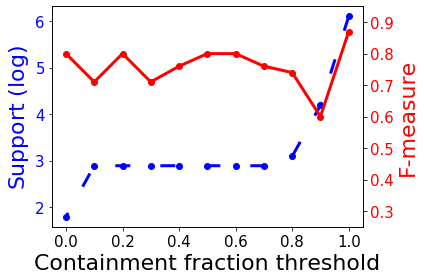

In [33]:
plot_fmeasures_and_supports(taxi_fmeasures[::-1], taxi_supports[::-1])

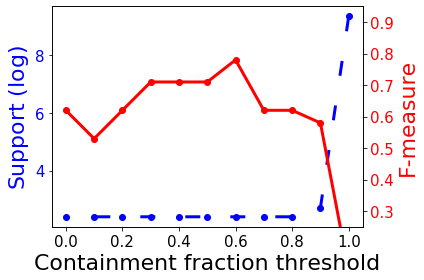

In [34]:
plot_fmeasures_and_supports(poverty_fmeasures[::-1], poverty_supports[::-1])

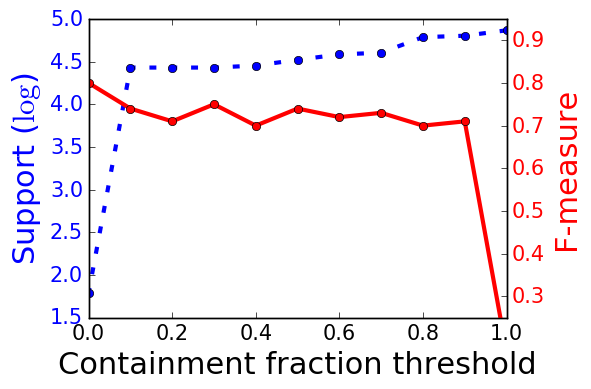

In [19]:
plot_fmeasures_and_supports(college_fmeasures[::-1], college_supports[::-1])

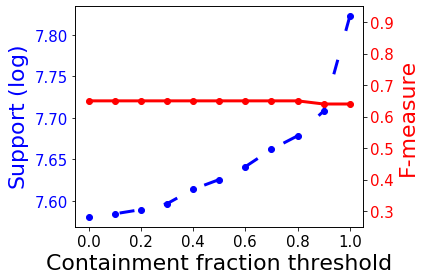

In [35]:
plot_fmeasures_and_supports(openml_test_fmeasures[::-1], openml_test_supports[::-1])

#### It seems like 0.8 is a reasonable threshold, but maybe this is something the user can choose and we just ALERT HER ABOUT THE CONSEQUENCES. For now, I'll work with containment_fraction >= 0.5

In [21]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
tmp_training = remove_low_containment_fraction_entries(openml_train, threshold=0.5)
rf.fit(tmp_training[CANDIDATE_PEARSON], tmp_training['class'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [22]:
tmp_test = remove_low_containment_fraction_entries(taxi, threshold=0.5)
preds = rf.predict(tmp_test[CANDIDATE_PEARSON])
print(classification_report(tmp_test['class'], preds))

              precision    recall  f1-score   support

        gain       1.00      0.67      0.80        18
        loss       0.00      0.00      0.00         0

   micro avg       0.67      0.67      0.67        18
   macro avg       0.50      0.33      0.40        18
weighted avg       1.00      0.67      0.80        18



#### Note that the precision is maximum but the recall isn't: there are a few false negatives. Let's examine all of them with eli5.

In [24]:
import eli5

tmp_test['pred'] = preds
false_negative = tmp_test.loc[(tmp_test['class'] == 'gain') & (tmp_test['pred'] == 'loss')]

false_negative.shape

/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


(6, 40)

In [25]:
no_bias = lambda feature_name, feature_value: feature_name != '<BIAS>'
eli5.show_prediction(rf, false_negative.iloc[0][CANDIDATE_PEARSON], 
                     feature_names=CANDIDATE_PEARSON, 
                     show_feature_values=True, feature_filter=no_bias)

In [26]:
no_bias = lambda feature_name, feature_value: feature_name != '<BIAS>'
eli5.show_prediction(rf, false_negative.iloc[1][CANDIDATE_PEARSON], 
                     feature_names=CANDIDATE_PEARSON, 
                     show_feature_values=True, feature_filter=no_bias)

In [27]:
no_bias = lambda feature_name, feature_value: feature_name != '<BIAS>'
eli5.show_prediction(rf, false_negative.iloc[2][CANDIDATE_PEARSON], 
                     feature_names=CANDIDATE_PEARSON, 
                     show_feature_values=True, feature_filter=no_bias)

In [28]:
no_bias = lambda feature_name, feature_value: feature_name != '<BIAS>'
eli5.show_prediction(rf, false_negative.iloc[3][CANDIDATE_PEARSON], 
                     feature_names=CANDIDATE_PEARSON, 
                     show_feature_values=True, feature_filter=no_bias)

In [29]:
no_bias = lambda feature_name, feature_value: feature_name != '<BIAS>'
eli5.show_prediction(rf, false_negative.iloc[4][CANDIDATE_PEARSON], 
                     feature_names=CANDIDATE_PEARSON, 
                     show_feature_values=True, feature_filter=no_bias)

In [30]:
no_bias = lambda feature_name, feature_value: feature_name != '<BIAS>'
eli5.show_prediction(rf, false_negative.iloc[5][CANDIDATE_PEARSON], 
                     feature_names=CANDIDATE_PEARSON, 
                     show_feature_values=True, feature_filter=no_bias)

#### Here, the pearson values were too low to identify these instances as positive.

In [31]:
tmp_test = remove_low_containment_fraction_entries(poverty, threshold=0.5)
preds = rf.predict(tmp_test[CANDIDATE_PEARSON])
print(classification_report(tmp_test['class'], preds))

              precision    recall  f1-score   support

        gain       1.00      0.55      0.71        11
        loss       0.00      0.00      0.00         0

   micro avg       0.55      0.55      0.55        11
   macro avg       0.50      0.27      0.35        11
weighted avg       1.00      0.55      0.71        11



#### Once again, the recall could be better. Let's see the false negatives.

In [32]:
tmp_test['pred'] = preds
false_negative = tmp_test.loc[(tmp_test['class'] == 'gain') & (tmp_test['pred'] == 'loss')]

false_negative.shape

no_bias = lambda feature_name, feature_value: feature_name != '<BIAS>'
eli5.show_prediction(rf, false_negative.iloc[0][CANDIDATE_PEARSON], 
                     feature_names=CANDIDATE_PEARSON, 
                     show_feature_values=True, feature_filter=no_bias)

/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [33]:
eli5.show_prediction(rf, false_negative.iloc[1][CANDIDATE_PEARSON], 
                     feature_names=CANDIDATE_PEARSON, 
                     show_feature_values=True, feature_filter=no_bias)

In [34]:
eli5.show_prediction(rf, false_negative.iloc[2][CANDIDATE_PEARSON], 
                     feature_names=CANDIDATE_PEARSON, 
                     show_feature_values=True, feature_filter=no_bias)

In [35]:
eli5.show_prediction(rf, false_negative.iloc[3][CANDIDATE_PEARSON], 
                     feature_names=CANDIDATE_PEARSON, 
                     show_feature_values=True, feature_filter=no_bias)

In [36]:
eli5.show_prediction(rf, false_negative.iloc[4][CANDIDATE_PEARSON], 
                     feature_names=CANDIDATE_PEARSON, 
                     show_feature_values=True, feature_filter=no_bias)

In [39]:
tmp_test = remove_low_containment_fraction_entries(college, threshold=0.5)
preds = rf.predict(tmp_test[CANDIDATE_PEARSON])
print(classification_report(tmp_test['class'], preds))

              precision    recall  f1-score   support

        gain       0.89      0.63      0.74        92
        loss       0.35      0.72      0.47        25

   micro avg       0.65      0.65      0.65       117
   macro avg       0.62      0.68      0.60       117
weighted avg       0.78      0.65      0.68       117



#### In the case of college, there are false positives and false negatives. They're also linked to irregularities in Pearson values. 

In [42]:
tmp_test = remove_low_containment_fraction_entries(openml_test, threshold=0.5)
preds = rf.predict(tmp_test[CANDIDATE_PEARSON])
print(classification_report(tmp_test['class'], preds))

              precision    recall  f1-score   support

        gain       0.67      0.62      0.65      2050
        loss       0.49      0.55      0.52      1371

   micro avg       0.59      0.59      0.59      3421
   macro avg       0.58      0.59      0.58      3421
weighted avg       0.60      0.59      0.60      3421



#### Same for openml_test. Let's add more features and see if the results improve, taking care of normalizing some of them first (the ones that do not have a fixed range).

In [57]:
from sklearn.preprocessing import StandardScaler
def normalize_feature(feature):
    standard_scaler = StandardScaler()
    norm = standard_scaler.fit_transform(np.array(feature).reshape(-1, 1))
    return list(norm.flatten())

In [62]:
tmp_training['query_num_of_columns'] = normalize_feature(tmp_training['query_num_of_columns'])
tmp_training['query_num_of_rows'] = normalize_feature(tmp_training['query_num_of_rows'])
tmp_training['query_row_column_ratio'] = normalize_feature(tmp_training['query_row_column_ratio'])
tmp_training['query_max_skewness'] = normalize_feature(tmp_training['query_max_skewness'])
tmp_training['query_max_kurtosis'] = normalize_feature(tmp_training['query_max_kurtosis'])
tmp_training['query_max_unique'] = normalize_feature(tmp_training['query_max_unique'])
tmp_training['query_target_max_covariance'] = normalize_feature(tmp_training['query_target_max_covariance'])
tmp_training['query_target_max_mutual_info'] = normalize_feature(tmp_training['query_target_max_mutual_info'])
tmp_training['candidate_num_of_columns'] = normalize_feature(tmp_training['candidate_num_of_columns'])
tmp_training['candidate_num_rows'] = normalize_feature(tmp_training['candidate_num_rows'])
tmp_training['candidate_row_column_ratio'] = normalize_feature(tmp_training['candidate_row_column_ratio'])
tmp_training['candidate_max_skewness'] = normalize_feature(tmp_training['candidate_max_skewness'])
tmp_training['candidate_max_kurtosis'] = normalize_feature(tmp_training['candidate_max_kurtosis'])
tmp_training['candidate_max_unique'] = normalize_feature(tmp_training['candidate_max_unique'])
tmp_training['candidate_target_max_covariance'] = normalize_feature(tmp_training['candidate_target_max_covariance'])
tmp_training['candidate_target_max_mutual_info'] = normalize_feature(tmp_training['candidate_target_max_mutual_info'])


/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [70]:
rf.fit(tmp_training[ALL_FEATURES], tmp_training['class'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [71]:
tmp_poverty = remove_low_containment_fraction_entries(poverty, threshold=0.5)
tmp_poverty['query_num_of_columns'] = normalize_feature(tmp_poverty['query_num_of_columns'])
tmp_poverty['query_num_of_rows'] = normalize_feature(tmp_poverty['query_num_of_rows'])
tmp_poverty['query_row_column_ratio'] = normalize_feature(tmp_poverty['query_row_column_ratio'])
tmp_poverty['query_max_skewness'] = normalize_feature(tmp_poverty['query_max_skewness'])
tmp_poverty['query_max_kurtosis'] = normalize_feature(tmp_poverty['query_max_kurtosis'])
tmp_poverty['query_max_unique'] = normalize_feature(tmp_poverty['query_max_unique'])
tmp_poverty['query_target_max_covariance'] = normalize_feature(tmp_poverty['query_target_max_covariance'])
tmp_poverty['query_target_max_mutual_info'] = normalize_feature(tmp_poverty['query_target_max_mutual_info'])
tmp_poverty['candidate_num_of_columns'] = normalize_feature(tmp_poverty['candidate_num_of_columns'])
tmp_poverty['candidate_num_rows'] = normalize_feature(tmp_poverty['candidate_num_rows'])
tmp_poverty['candidate_row_column_ratio'] = normalize_feature(tmp_poverty['candidate_row_column_ratio'])
tmp_poverty['candidate_max_skewness'] = normalize_feature(tmp_poverty['candidate_max_skewness'])
tmp_poverty['candidate_max_kurtosis'] = normalize_feature(tmp_poverty['candidate_max_kurtosis'])
tmp_poverty['candidate_max_unique'] = normalize_feature(tmp_poverty['candidate_max_unique'])
tmp_poverty['candidate_target_max_covariance'] = normalize_feature(tmp_poverty['candidate_target_max_covariance'])
tmp_poverty['candidate_target_max_mutual_info'] = normalize_feature(tmp_poverty['candidate_target_max_mutual_info'])

preds = rf.predict(tmp_poverty[ALL_FEATURES])
print(classification_report(tmp_poverty['class'], preds))

/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

              precision    recall  f1-score   support

        gain       1.00      1.00      1.00        11

   micro avg       1.00      1.00      1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



#### Whoah, the results got perfect for this combination!

In [72]:
tmp_taxi = remove_low_containment_fraction_entries(taxi, threshold=0.5)
tmp_taxi['query_num_of_columns'] = normalize_feature(tmp_taxi['query_num_of_columns'])
tmp_taxi['query_num_of_rows'] = normalize_feature(tmp_taxi['query_num_of_rows'])
tmp_taxi['query_row_column_ratio'] = normalize_feature(tmp_taxi['query_row_column_ratio'])
tmp_taxi['query_max_skewness'] = normalize_feature(tmp_taxi['query_max_skewness'])
tmp_taxi['query_max_kurtosis'] = normalize_feature(tmp_taxi['query_max_kurtosis'])
tmp_taxi['query_max_unique'] = normalize_feature(tmp_taxi['query_max_unique'])
tmp_taxi['query_target_max_covariance'] = normalize_feature(tmp_taxi['query_target_max_covariance'])
tmp_taxi['query_target_max_mutual_info'] = normalize_feature(tmp_taxi['query_target_max_mutual_info'])
tmp_taxi['candidate_num_of_columns'] = normalize_feature(tmp_taxi['candidate_num_of_columns'])
tmp_taxi['candidate_num_rows'] = normalize_feature(tmp_taxi['candidate_num_rows'])
tmp_taxi['candidate_row_column_ratio'] = normalize_feature(tmp_taxi['candidate_row_column_ratio'])
tmp_taxi['candidate_max_skewness'] = normalize_feature(tmp_taxi['candidate_max_skewness'])
tmp_taxi['candidate_max_kurtosis'] = normalize_feature(tmp_taxi['candidate_max_kurtosis'])
tmp_taxi['candidate_max_unique'] = normalize_feature(tmp_taxi['candidate_max_unique'])
tmp_taxi['candidate_target_max_covariance'] = normalize_feature(tmp_taxi['candidate_target_max_covariance'])
tmp_taxi['candidate_target_max_mutual_info'] = normalize_feature(tmp_taxi['candidate_target_max_mutual_info'])

preds = rf.predict(tmp_taxi[ALL_FEATURES])
print(classification_report(tmp_taxi['class'], preds))

/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

              precision    recall  f1-score   support

        gain       1.00      0.83      0.91        18
        loss       0.00      0.00      0.00         0

   micro avg       0.83      0.83      0.83        18
   macro avg       0.50      0.42      0.45        18
weighted avg       1.00      0.83      0.91        18



/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### The recall increased (from 0.67 to 0.83). I'll investigate the false negatives soon.

In [73]:
tmp_college = remove_low_containment_fraction_entries(college, threshold=0.5)
tmp_college['query_num_of_columns'] = normalize_feature(tmp_college['query_num_of_columns'])
tmp_college['query_num_of_rows'] = normalize_feature(tmp_college['query_num_of_rows'])
tmp_college['query_row_column_ratio'] = normalize_feature(tmp_college['query_row_column_ratio'])
tmp_college['query_max_skewness'] = normalize_feature(tmp_college['query_max_skewness'])
tmp_college['query_max_kurtosis'] = normalize_feature(tmp_college['query_max_kurtosis'])
tmp_college['query_max_unique'] = normalize_feature(tmp_college['query_max_unique'])
tmp_college['query_target_max_covariance'] = normalize_feature(tmp_college['query_target_max_covariance'])
tmp_college['query_target_max_mutual_info'] = normalize_feature(tmp_college['query_target_max_mutual_info'])
tmp_college['candidate_num_of_columns'] = normalize_feature(tmp_college['candidate_num_of_columns'])
tmp_college['candidate_num_rows'] = normalize_feature(tmp_college['candidate_num_rows'])
tmp_college['candidate_row_column_ratio'] = normalize_feature(tmp_college['candidate_row_column_ratio'])
tmp_college['candidate_max_skewness'] = normalize_feature(tmp_college['candidate_max_skewness'])
tmp_college['candidate_max_kurtosis'] = normalize_feature(tmp_college['candidate_max_kurtosis'])
tmp_college['candidate_max_unique'] = normalize_feature(tmp_college['candidate_max_unique'])
tmp_college['candidate_target_max_covariance'] = normalize_feature(tmp_college['candidate_target_max_covariance'])
tmp_college['candidate_target_max_mutual_info'] = normalize_feature(tmp_college['candidate_target_max_mutual_info'])

preds = rf.predict(tmp_college[ALL_FEATURES])
print(classification_report(tmp_college['class'], preds))


/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

              precision    recall  f1-score   support

        gain       0.82      0.91      0.87        92
        loss       0.47      0.28      0.35        25

   micro avg       0.78      0.78      0.78       117
   macro avg       0.65      0.60      0.61       117
weighted avg       0.75      0.78      0.76       117



/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

#### The precision lowered a bit (from 0.89 to 0.82), the recall increased (from 0.63 to 0.91).

In [74]:
tmp_openml_test = remove_low_containment_fraction_entries(openml_test, threshold=0.5)
tmp_openml_test['query_num_of_columns'] = normalize_feature(tmp_openml_test['query_num_of_columns'])
tmp_openml_test['query_num_of_rows'] = normalize_feature(tmp_openml_test['query_num_of_rows'])
tmp_openml_test['query_row_column_ratio'] = normalize_feature(tmp_openml_test['query_row_column_ratio'])
tmp_openml_test['query_max_skewness'] = normalize_feature(tmp_openml_test['query_max_skewness'])
tmp_openml_test['query_max_kurtosis'] = normalize_feature(tmp_openml_test['query_max_kurtosis'])
tmp_openml_test['query_max_unique'] = normalize_feature(tmp_openml_test['query_max_unique'])
tmp_openml_test['query_target_max_covariance'] = normalize_feature(tmp_openml_test['query_target_max_covariance'])
tmp_openml_test['query_target_max_mutual_info'] = normalize_feature(tmp_openml_test['query_target_max_mutual_info'])
tmp_openml_test['candidate_num_of_columns'] = normalize_feature(tmp_openml_test['candidate_num_of_columns'])
tmp_openml_test['candidate_num_rows'] = normalize_feature(tmp_openml_test['candidate_num_rows'])
tmp_openml_test['candidate_row_column_ratio'] = normalize_feature(tmp_openml_test['candidate_row_column_ratio'])
tmp_openml_test['candidate_max_skewness'] = normalize_feature(tmp_openml_test['candidate_max_skewness'])
tmp_openml_test['candidate_max_kurtosis'] = normalize_feature(tmp_openml_test['candidate_max_kurtosis'])
tmp_openml_test['candidate_max_unique'] = normalize_feature(tmp_openml_test['candidate_max_unique'])
tmp_openml_test['candidate_target_max_covariance'] = normalize_feature(tmp_openml_test['candidate_target_max_covariance'])
tmp_openml_test['candidate_target_max_mutual_info'] = normalize_feature(tmp_openml_test['candidate_target_max_mutual_info'])

preds = rf.predict(tmp_openml_test[ALL_FEATURES])
print(classification_report(tmp_openml_test['class'], preds))

/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/alibezz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

              precision    recall  f1-score   support

        gain       0.67      0.62      0.64      2050
        loss       0.48      0.54      0.51      1371

   micro avg       0.59      0.59      0.59      3421
   macro avg       0.58      0.58      0.58      3421
weighted avg       0.59      0.59      0.59      3421

